In [126]:
import requests

import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

import geopandas as gpd
import geojson
from shapely.geometry import Point, LineString
import flexpolyline


In [127]:
img = cv2.imread('s.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

corners = cv2.goodFeaturesToTrack(gray, 100, 0.001, 100)
corners = np.int0(corners)

In [128]:
squeezed = corners.squeeze().tolist()
print(squeezed)

[[2, 331], [2205, 449], [2196, 571], [20, 666], [39, 827], [2177, 753], [2154, 924], [9, 534], [2132, 1053], [91, 1122], [135, 1300], [2085, 1258], [2114, 300], [1822, 212], [1688, 172], [531, 170], [1584, 141], [1460, 104], [879, 64], [1283, 51], [992, 30], [1126, 4], [71, 1022], [2032, 1437], [2015, 270], [226, 262], [754, 102], [343, 227], [223, 1557], [169, 1414], [101, 299], [1090, 2442], [1191, 2415], [1985, 1563], [636, 138], [1944, 1660], [979, 2395], [278, 1682], [1284, 2374], [2111, 1151], [1795, 1928], [382, 1879], [856, 2335], [1498, 2242], [1849, 1843], [766, 2275], [1721, 2026], [1405, 2309], [678, 2210], [1591, 2165], [458, 1985], [530, 2071], [1899, 1754], [601, 2144], [1918, 241], [330, 1789]]


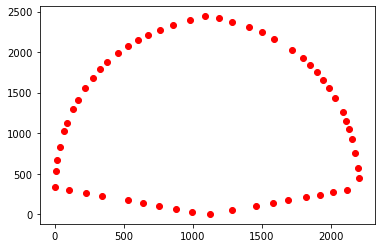

In [129]:
squeezed = corners.squeeze().tolist()

x_squeezed = np.array([i[0] for i in squeezed])
y_squeezed = np.array([i[1] for i in squeezed])

plt.plot(x_squeezed, y_squeezed, 'ro')

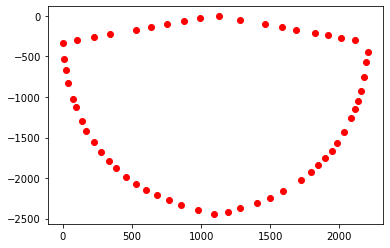

In [130]:
plt.plot(x_squeezed, -y_squeezed, 'ro')

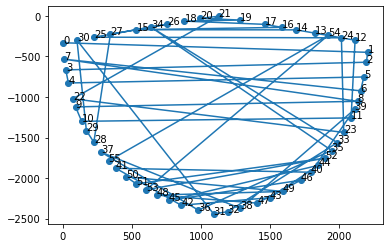

In [131]:
matrix = np.array([x_squeezed, -y_squeezed])

plt.plot(matrix[0], matrix[1], marker='o')
for index, coord in enumerate(matrix[0]):
    plt.text(coord, matrix[1][index], str(index))

In [132]:
def distance(P1, P2):
    """
    This function computes the distance between 2 points defined by
     P1 = (x1,y1) and P2 = (x2,y2) 
    """
    return ((P1[0] - P2[0])**2 + (P1[1] - P2[1])**2) ** 0.5


def optimized_path(coords, start=None):
    """
    This function finds the nearest point to a point
    coords should be a list in this format coords = [ [x1, y1], [x2, y2] , ...] 

    """
    if start is None:
        start = coords[0]
    pass_by = coords
    path = [start]
    pass_by.remove(start)
    while pass_by:
        nearest = min(pass_by, key=lambda x: distance(path[-1], x))
        path.append(nearest)
        pass_by.remove(nearest)
    return path

In [133]:
path = optimized_path(squeezed)
print(path)

[[2, 331], [101, 299], [226, 262], [343, 227], [531, 170], [636, 138], [754, 102], [879, 64], [992, 30], [1126, 4], [1283, 51], [1460, 104], [1584, 141], [1688, 172], [1822, 212], [1918, 241], [2015, 270], [2114, 300], [2205, 449], [2196, 571], [2177, 753], [2154, 924], [2132, 1053], [2111, 1151], [2085, 1258], [2032, 1437], [1985, 1563], [1944, 1660], [1899, 1754], [1849, 1843], [1795, 1928], [1721, 2026], [1591, 2165], [1498, 2242], [1405, 2309], [1284, 2374], [1191, 2415], [1090, 2442], [979, 2395], [856, 2335], [766, 2275], [678, 2210], [601, 2144], [530, 2071], [458, 1985], [382, 1879], [330, 1789], [278, 1682], [223, 1557], [169, 1414], [135, 1300], [91, 1122], [71, 1022], [39, 827], [20, 666], [9, 534]]


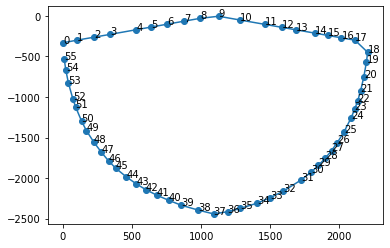

In [134]:
x = np.array([i[0] for i in path])
y = np.array([i[1] for i in path])

matrix = np.array([x, -y])

plt.plot(matrix[0], matrix[1], marker='o')
for index, coord in enumerate(matrix[0]):
    plt.text(coord, matrix[1][index], str(index))

In [166]:
meters = 10

# Координаты в системе координат EPSG:3857
x_original_point = 4173551.0
y_original_point = 7529089.9

mx = x * meters + x_original_point
my = y * -meters + y_original_point

mxy = list(zip(mx,my))

picture_df = gpd.GeoDataFrame(
    {'id': range(0, len(mxy))}, 
    crs="EPSG:3857", 
    geometry=[Point(resu) for resu in mxy]
)


picture_df.to_file("cat.geojson", driver='GeoJSON', encoding="utf-8")

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'cat.geojson'

In [175]:

SERVICE = 'https://router.hereapi.com/v8/routes?apiKey=ef8Pr_JrPWwwYdHi9-BGSBOb0mobWWFs-GFnh-MfTGc&transportMode=pedestrian&return=polyline'
file = open('cat.geojson')
data = geojson.load(file).copy()
file.close()

In [176]:
coords_list = [feature['geometry']['coordinates'] for feature in data['features']]

start_point = coords_list[0]
destination_point = coords_list[len(coords_list) -1]

coords_list.remove(start_point)
coords_list.remove(destination_point)

In [184]:
origin = f'&origin={start_point[1]},{start_point[0]}'
destination = f'&destination={destination_point[1]},{destination_point[0]}&'
waypoints = '&'.join([f'via={coords[1]},{coords[0]}' for coords in coords_list])

In [192]:
routes = requests.get(SERVICE + origin + destination + waypoints).json()

In [193]:
def decode (section):
    line = flexpolyline.decode(section['polyline'])
    line = [(coord[1], coord[0])  for coord in line]
    return LineString(line)

geometry = [decode(section) for section in routes['routes'][0]['sections']]

KeyError: 'routes'

In [194]:
route_df = gpd.GeoDataFrame(geometry=geometry)

route_df.to_file("route.geojson", driver='GeoJSON', encoding="utf-8")

NameError: name 'geometry' is not defined